**Topics:**
* Manual detection of outliers = image stack with too many artifacts.
* Check image and tumor GL distr. (compare dynamic ranges and contrasts across patients).
* Check if improvement with histogram equalization.
* Compare images by SSMI.
* Check if improvement with MAR.

In [8]:
import sys
sys.path.append('./')

import os
import re
import nrrd

from _backend import ioutil
from pathlib import Path
from matplotlib.colors import ListedColormap

import numpy as np
import pandas as pd

from skimage.measure import compare_ssim as ssim

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
#!pip install scikit-image -U

In [10]:
paths_to_ct = ioutil.relative_paths('./../../../data_source/images/ct_nrrd', target_format='nrrd')
paths_to_pet = ioutil.relative_paths('./../../../data_source/images/pet_nrrd', target_format='nrrd')
paths_to_mask = ioutil.relative_paths('./../../../data_source/images/masks_nrrd', target_format='nrrd')
ct, pet = {}, {}
ct_cropped, pet_cropped = {}, {} 
for num, path_to_ct in enumerate(paths_to_ct):
    
    ct_image, _ = nrrd.read(path_to_ct)
    ct[path_to_ct] = ct_image
    
    pet_image, _ = nrrd.read(paths_to_pet[num])
    pet[paths_to_pet[num]] = pet_image
    
    mask_image, _ = nrrd.read(paths_to_mask[num])
    
    ct_cropped[path_to_ct] = ct[path_to_ct] * mask_image

    pet_cropped[paths_to_pet[num]] = pet[paths_to_pet[num]] * mask_image

# Manual outlier detection

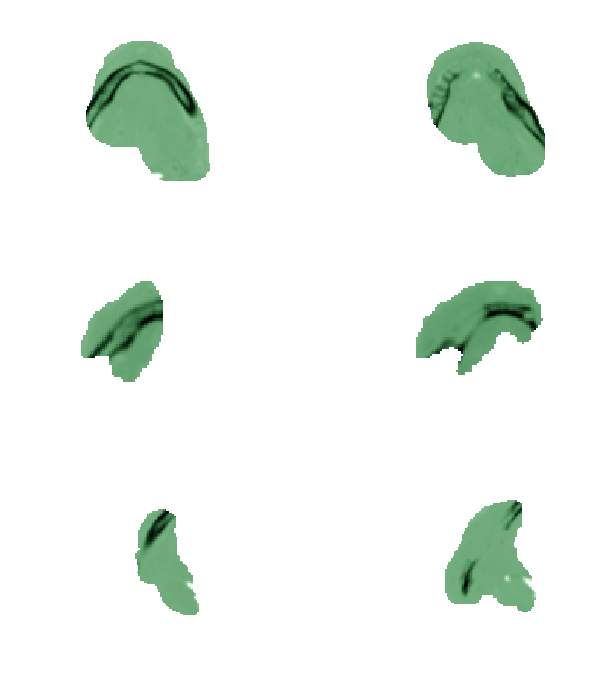

In [11]:
# Tumor regions from patients removed from the data set. Images were manually inspected prior to analysis. 
# Three CT volumes were determined to contain too many artifacts to be included in the analysis, and were, 
# thus, removed from the data.
images_to_drop = [
    ct_cropped['./../../../data_source/images/ct_nrrd/P038CT.nrrd'][:, :, 60],
    ct_cropped['./../../../data_source/images/ct_nrrd/P038CT.nrrd'][:, :, 70],
    ct_cropped['./../../../data_source/images/ct_nrrd/P045CT.nrrd'][:, :, 30],
    ct_cropped['./../../../data_source/images/ct_nrrd/P045CT.nrrd'][:, :, 35],
    ct_cropped['./../../../data_source/images/ct_nrrd/P082CT.nrrd'][:, :, 40],
    ct_cropped['./../../../data_source/images/ct_nrrd/P082CT.nrrd'][:, :, 50],
]

cmap = ListedColormap(sns.cubehelix_palette(400, start=2, rot=0, dark=0, light=1, reverse=False))
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
for num, axis in enumerate(axes.ravel()):
    axis.imshow(
        images_to_drop[num], 
        cmap=cmap,
        vmin=np.min(images_to_drop[num]), 
        vmax=np.max(images_to_drop[num])
    )
    axis.axis('off')
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig(
    './../../../figures/dropped_samples.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

**Update data to inspect**

In [12]:
# Patient IDs to skip in analysis.
#DROPPED = [38, 45, 82]

In [13]:
# Drop outliers from data to inspect.
paths_to_drop = [
    './../../../data_source/images/ct_nrrd/P038CT.nrrd',
    './../../../data_source/images/ct_nrrd/P045CT.nrrd',
    './../../../data_source/images/ct_nrrd/P082CT.nrrd'
]
ct_ad, pet_ad = {}, {}
ct_cropped_ad, pet_cropped_ad = {}, {} 
for num, path_to_ct in enumerate(paths_to_ct):
    
    if path_to_ct in paths_to_drop:
        pass
    else:
        ct_ad[path_to_ct] = ct[path_to_ct]
        pet_ad[paths_to_pet[num]] = pet[paths_to_pet[num]]

        ct_cropped_ad[path_to_ct] = ct_cropped[path_to_ct]
        pet_cropped_ad[paths_to_pet[num]] = pet_cropped[paths_to_pet[num]]

# Image VS Tumor Graylevel Statistics

In [14]:
def calc_image_statistics(image):
    
    return {
        'gl_mean': np.mean(image),
        'gl_median': np.median(image),
        'gl_min': np.min(image),
        'gl_max': np.max(image)
    }

In [15]:
# Statistics on complete (not cropped) images.
ct_ad_stats, pet_ad_stats = {}, {}
for num, (pet_image, ct_image) in enumerate(zip(pet_ad.values(), ct_ad.values())):
    
    pet_ad_stats[num] = calc_image_statistics(pet_image)
    ct_ad_stats[num] = calc_image_statistics(ct_image)

# Statistics on tumor (cropped) images.
ct_cropped_ad_stats, pet_cropped_ad_stats = {}, {}
for num, (pet_image, ct_image) in enumerate(zip(pet_cropped_ad.values(), ct_cropped_ad.values())):
    
    pet_cropped_ad_stats[num] = calc_image_statistics(pet_image)
    ct_cropped_ad_stats[num] = calc_image_statistics(ct_image)

df_ct_ad_stats = pd.DataFrame(ct_ad_stats)
df_ct_cropped_ad_stats = pd.DataFrame(ct_cropped_ad_stats)

df_pet_ad_stats = pd.DataFrame(pet_ad_stats)
df_pet_cropped_ad_stats = pd.DataFrame(pet_cropped_ad_stats)

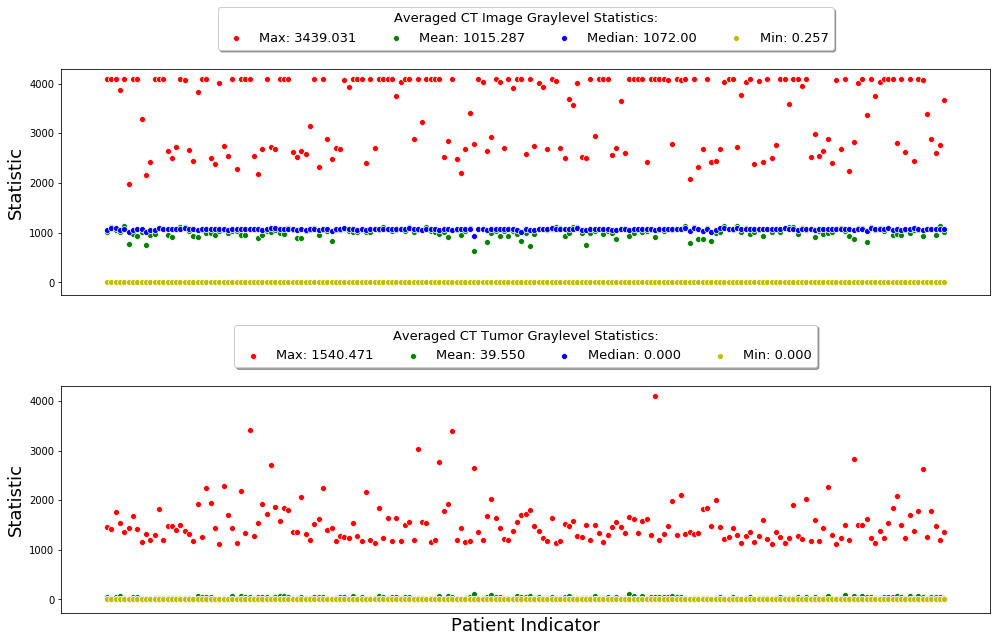

In [16]:
from matplotlib import rcParams, cycler

rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])

# Plot CT image and tumor GL stats. 

# Observations: 
# * The difference between average max in the complete and cropped image illustrates the significant amount of 
#   artifacts in each image. 

fig, (image_axis, cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
for ct_cropped_row_label, ct_row_label in zip(df_ct_cropped_ad_stats.T, df_ct_ad_stats.T):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_ct_ad_stats.columns.values), 
        y=np.squeeze(df_ct_ad_stats.loc[ct_row_label, :].values),
        ax=image_axis,
    )
    # Plot tupr stats.
    sns.scatterplot(
        x=np.squeeze(df_ct_cropped_ad_stats.columns.values), 
        y=np.squeeze(df_ct_cropped_ad_stats.loc[ct_cropped_row_label, :].values),
        ax=cropped_axis,
    )
image_axis.legend(
    [
        'Max: {:.3f}'.format(df_ct_ad_stats.loc['gl_max'].mean()), 
        'Mean: {:.3f}'.format(df_ct_ad_stats.loc['gl_mean'].mean()), 
        'Median: {:.2f}'.format(df_ct_ad_stats.loc['gl_median'].mean()),
        'Min: {:.3f}'.format(df_ct_ad_stats.loc['gl_min'].mean()),
    ],
    title='Averaged CT Image Graylevel Statistics:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.3),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
cropped_axis.legend(
    [
        'Max: {:.3f}'.format(df_ct_cropped_ad_stats.loc['gl_max'].mean()), 
        'Mean: {:.3f}'.format(df_ct_cropped_ad_stats.loc['gl_mean'].mean()),
        'Median: {:.3f}'.format(df_ct_cropped_ad_stats.loc['gl_median'].mean()), 
        'Min: {:.3f}'.format(df_ct_cropped_ad_stats.loc['gl_min'].mean())
    ],
    title='Averaged CT Tumor Graylevel Statistics:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.3),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
image_axis.set_ylabel('Statistic', fontsize=18)
cropped_axis.set_ylabel('Statistic', fontsize=18)
plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.savefig(
    './../../../figures/ct_gl_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

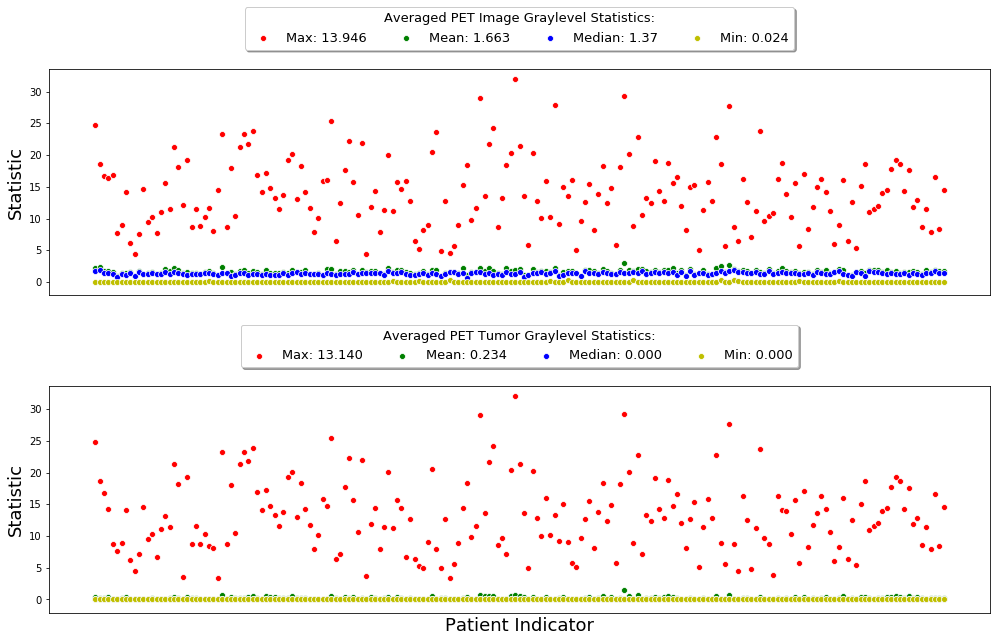

In [17]:
# Plot CT image and tumor GL stats.
#from matplotlib import rcParams, cycler

#colours = sns.diverging_palette(255, 133, l=60, n=4, center="dark")
#rcParams['axes.prop_cycle'] = cycler(color=colours)

fig, (image_axis, cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
for pet_cropped_row_label, pet_row_label in zip(df_pet_cropped_ad_stats.T, df_pet_ad_stats.T):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_ad_stats.columns.values), 
        y=np.squeeze(df_pet_ad_stats.loc[pet_row_label, :].values),
        ax=image_axis,
    )
    # Plot tupr stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_cropped_ad_stats.columns.values), 
        y=np.squeeze(df_pet_cropped_ad_stats.loc[pet_cropped_row_label, :].values),
        ax=cropped_axis,
    )
image_axis.legend(
    [
        'Max: {:.3f}'.format(df_pet_ad_stats.loc['gl_max'].mean()), 
        'Mean: {:.3f}'.format(df_pet_ad_stats.loc['gl_mean'].mean()), 
        'Median: {:.2f}'.format(df_pet_ad_stats.loc['gl_median'].mean()),
        'Min: {:.3f}'.format(df_pet_ad_stats.loc['gl_min'].mean()),
    ],
    title='Averaged PET Image Graylevel Statistics:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.3),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
cropped_axis.legend(
    [
        'Max: {:.3f}'.format(df_pet_cropped_ad_stats.loc['gl_max'].mean()), 
        'Mean: {:.3f}'.format(df_pet_cropped_ad_stats.loc['gl_mean'].mean()),
        'Median: {:.3f}'.format(df_pet_cropped_ad_stats.loc['gl_median'].mean()), 
        'Min: {:.3f}'.format(df_pet_cropped_ad_stats.loc['gl_min'].mean())
    ],
    title='Averaged PET Tumor Graylevel Statistics:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.3),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
image_axis.set_ylabel('Statistic', fontsize=18)
cropped_axis.set_ylabel('Statistic', fontsize=18)
plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.savefig(
    './../../../figures/pet_gl_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Inspecting potential CT max value groups

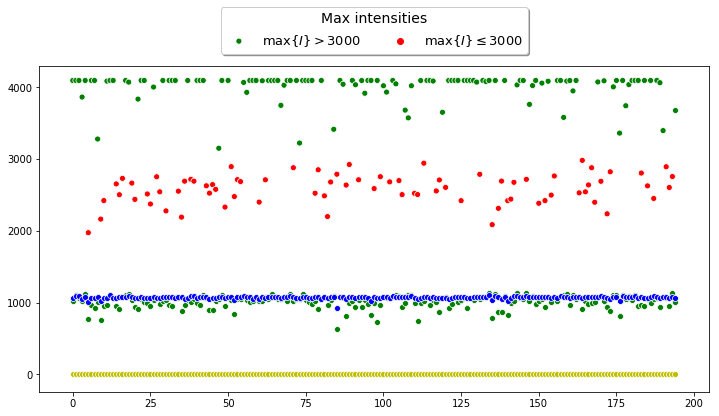

In [47]:
# Observations: 
# * Can separate patients into two groups based on max CT intensities (I > 3000).

df_ct_ad_max = df_ct_ad_stats.loc['gl_max', :].values
plt.figure(figsize=(12, 6))
for ct_row_label in df_ct_ad_stats.T:
    # Plot image stats.
    if 'max' in ct_row_label:
        sns.scatterplot(
            x=np.squeeze(df_ct_ad_stats.columns.values), 
            y=np.squeeze(df_ct_ad_stats.loc[ct_row_label, :].values),
            hue=df_ct_ad_max > 3000,
        )
    else:
        sns.scatterplot(
            x=np.squeeze(df_ct_ad_stats.columns.values), 
            y=np.squeeze(df_ct_ad_stats.loc[ct_row_label, :].values),
        )
        #pass
plt.legend(
    [r'$\max \left \{ I \right \} > 3000$', r'$\max \left \{ I \right \} \leq 3000$'],
    title='Max intensities',
    title_fontsize=14,
    fontsize=13,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.2),
    ncol=2, 
    fancybox=True, 
    shadow=True
)

# Tumor contrast and dynamic range

In [19]:
# CT intensity range: 2 ** 12

# TODO:
# * Contrast = the difference Imax - Imin
# * Dynamic range = the number of distinct image values.

# Histogram equalization

In [20]:
# TODO: Use a statistic to compare quality of images before and after histogram equalization.
# * http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py

# Structural similarity index

In [41]:
largest_tumor_image = ct_cropped_ad['./../../../data_source/images/ct_nrrd/P114CT.nrrd']
X_dim_size = np.unique(np.where(largest_tumor_image != 0)[0]).size
Y_dim_size = np.unique(np.where(largest_tumor_image != 0)[1]).size
Z_dim_size = np.unique(np.where(largest_tumor_image != 0)[2]).size

X_dim_size, Y_dim_size, Z_dim_size

(106, 95, 100)

In [51]:
# Structural similarity index (SSIM) is used for measuring the similarity between two images. 
ssim_vals = np.zeros((len(ct_cropped_ad.keys()), len(ct_cropped_ad.keys())), dtype=np.float32)
for ref_num, ref_ct_image in enumerate(ct_cropped_ad.values()):
    for sample_num, sample_ct_image in enumerate(ct_cropped_ad.values()):
        # Resize images to largest tumor size and insert image values.
        # See: https://stackoverflow.com/questions/41171034/how-does-the-numpy-resize-and-numpy-reshape-function-works-internally-in-python
        _ref_ct_image = np.resize(ref_ct_image, (X_dim_size, Y_dim_size, Z_dim_size))
        _sample_ct_image = np.resize(sample_ct_image, (X_dim_size, Y_dim_size, Z_dim_size))
        # skimage.measure.compare_ssim
        # http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim

        #ssim_vals[ref_num, sample_num] = 
        #stat, _, _ = compare_ssim(
        #    X=_ref_ct_image, 
        #    Y=_sample_ct_image, 
        #    gaussian_weights=True,
        #    gradient=False,
        #    multichannel=False,
        #   
        #    data_range=np.max(_sample_ct_image) - np.min(_sample_ct_image),
        #    full=False,
        #)

KeyboardInterrupt: 

# Metal artifact reduction 

In [ ]:
# TODO:

# HPV status vs. Sex

* Typical that women (not men) recieve HPV vaccine.
* If HPV is predictive: Norwegian gov. intro. free vaccine. 

In [ ]:
DROPPED = [38, 45, 82]

y = pd.read_csv('./../../../data_source/to_analysis/target_dfs.csv', index_col=0)
orig_size = np.size(y)
y.drop(DROPPED, inplace=True)
new_size = np.size(y)
y = np.squeeze(y.values)
# Sanity check.
assert orig_size == new_size + len(DROPPED)

clinical = pd.read_excel('./../../../data_source/tabular/clinical_params.xlsx', index_col=0)
clinical.drop(DROPPED, inplace=True)
clinical.head()

In [ ]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.5)
sns.violinplot(x='Kjønn', y='HPV-status', data=clinical)
plt.xticks([0, 1], ['M', 'F'])
plt.xlabel('Patient Sex')
plt.ylabel('HPV Status')
plt.tight_layout()
plt.savefig(
    './../../../figures/sex_vs_hpv.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Sex distribution

In [ ]:
sns.set(style='whitegrid')
fig = plt.figure(figsize=(8, 6))
axis = sns.countplot(x='Kjønn', data=clinical, saturation=0.85)

plt.ylabel('Count', fontsize=16)
plt.xlabel('Sex', fontsize=16)
plt.xticks(range(2), ['Female', 'Male'], fontsize=14)

sex_ratios = [
    sum(clinical['Kjønn'] == 'M') / clinical['Kjønn'].size, 
    sum(clinical['Kjønn'] == 'K') / clinical['Kjønn'].size, 
]
for num, patch in enumerate(axis.patches):
    plt.annotate(
        '{:.1f}%'.format(sex_ratios[num] * 100),
        (patch.get_x() + patch.get_width() / 2.5, patch.get_height() + 1), 
        color='k', fontsize=14
    )
plt.tight_layout()
plt.savefig(
    './../../../figures/sex_distr.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Outcome distribution

In [ ]:
# DO TO: Divide each bar into sex distr.?
sns.set(style='whitegrid')
fig = plt.figure(figsize=(8, 6))
axis = sns.countplot(x=y, saturation=0.85)

plt.ylabel('Count', fontsize=16)
plt.xlabel('Progression-Free Survival', fontsize=16)
plt.xticks(range(2), ['True', 'False'], fontsize=14)

dfs_ratios = [1 - sum(y) / y.size, sum(y) / y.size, ]
for num, patch in enumerate(axis.patches):
    plt.annotate(
        '{:.1f}%'.format(dfs_ratios[num] * 100),
        (patch.get_x() + patch.get_width() / 2.5, patch.get_height() + 1), 
        color='k', fontsize=14
    )
      
plt.tight_layout()
plt.savefig(
    './../../../figures/outcome_distr.png', 
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)